In [19]:
import tensorflow as tf
from tensorflow import keras

In [20]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

In [21]:
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.1))

In [22]:
codings_size = 30

In [23]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(784, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="relu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])



In [24]:
[X_train, y_train ], [X_test, y_test] = keras.datasets.cifar10.load_data()

In [25]:
X_train = X_train/255
y_train = y_train/255

In [26]:
X_train.shape

(50000, 32, 32, 3)

In [27]:
denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [28]:
denoising_encoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
N

In [33]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [34]:
denoising_decoder.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8192)              4202496   
                                                                 
 reshape_4 (Reshape)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 3)        867       
 ranspose)                                                       
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [43]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=,
                           validation_data=(X_test, X_test))

Epoch 1/5
1563/1563 [==============================] - 145s 92ms/step - loss: 0.5791 - mse: 0.0119 - val_loss: -123397.0078 - val_mse: 18631.8613
Epoch 2/5
1563/1563 [==============================] - 144s 92ms/step - loss: 0.5673 - mse: 0.0079 - val_loss: -178352.2188 - val_mse: 18631.2520
Epoch 3/5
1563/1563 [==============================] - 144s 92ms/step - loss: 0.5665 - mse: 0.0076 - val_loss: -210350.2500 - val_mse: 18631.2363
Epoch 4/5
1563/1563 [==============================] - 144s 92ms/step - loss: 0.5660 - mse: 0.0075 - val_loss: -281799.2812 - val_mse: 18631.1113
Epoch 5/5
1563/1563 [==============================] - 144s 92ms/step - loss: 0.5656 - mse: 0.0073 - val_loss: -328983.3750 - val_mse: 18631.1016


1/1 [==============================] - 0s 16ms/step


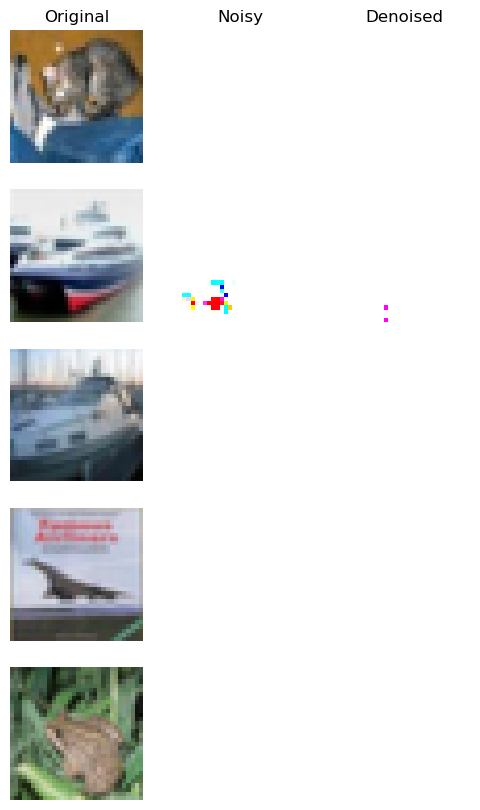

In [51]:
import numpy as np
import matplotlib.pyplot as plt
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()